# BBM 409 - Programming Assignment 3

### Erdinç Arıcı - 2210356035

## 1 Implementing a CNN from Scratch

### 1.1 Introduction

The aim of this task is to apply different deep learning models to classify images in the Animal-10 dataset and evaluate their performance. Architectures such as CNN, ResNet18, and MobileNetV2 are utilized to achieve high accuracy in the classification task. Specifically, the use of pretrained models enhances classification accuracy and facilitates the comparison of overall model performance.

CNN architecture is a fundamental structure used in image classification tasks. The main components of a CNN include convolutional layers, activation functions, pooling layers, fully connected layers, and regularization techniques such as dropout. This architecture effectively learns local features in images. Convolutional layers use filters to extract meaningful features from the image, while pooling layers reduce the dimensions of these features, transforming them into a more compact form. Activation functions introduce non-linearity, enabling the learning of more complex relationships. Therefore, CNNs are considered one of the most successful architectures for image classification due to their ability to learn both local and global features.

The Animal-10 dataset used in this task consists of 10 different animal classes. The dataset contains a total of 30,000 images representing various animal species. Being a balanced dataset makes it ideal for fairly evaluating model performance across different classes.

### 1.2 Data loading and preprocessing

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
import torch.nn.functional as nnf
from google.colab import drive, files
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/animal_10'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(path, transform)

train_dataset, val_dataset, test_dataset = random_split(dataset, [3000, 750, 750])

train_loader = DataLoader(train_dataset, 64, True, num_workers = 12, pin_memory = True)
val_loader = DataLoader(val_dataset, 64, False, num_workers = 12, pin_memory = True)
test_loader = DataLoader(test_dataset, 64, False, num_workers = 12, pin_memory = True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.3 Define your CNN architecture

In [3]:
class CNN(nn.Module):
    def __init__(self, classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv5 = nn.Conv2d(256, 512, 3, 1, 1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)

        self.fc1 = nn.Linear(512 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, classes)

        self.pool = nn.MaxPool2d(2, 2, 0)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nnf.relu(self.bn1(self.conv1(x))))
        x = self.pool(nnf.relu(self.bn2(self.conv2(x))))
        x = self.pool(nnf.relu(self.bn3(self.conv3(x))))
        x = self.pool(nnf.relu(self.bn4(self.conv4(x))))
        x = self.pool(nnf.relu(self.bn5(self.conv5(x))))

        x = x.view(x.size(0), -1)

        x = nnf.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = CNN()
cnn_model = cnn_model.to(device)

This CNN architecture is designed to classify images in the Animal-10 dataset. The architecture consists of five consecutive convolutional layers for feature extraction. Increasing the number of output channels as the layers progress allows the model to have a greater capacity for extracting complex features. Batch Normalization is applied after each convolutional layer to speed up the learning process and improve the stability of the model. MaxPooling layers are used after each convolutional layer to reduce spatial dimensions. This process decreases the number of parameters, reduces computational cost, and lowers the risk of overfitting. After feature extraction, the data is flattened and passed to fully connected layers for classification. The first fully connected layer combines the extracted features densely, while the second fully connected layer maps this information to 10 different classes in the Animal-10 dataset.

I chose the ReLU activation function for this architecture. ReLU introduces non-linearity, enabling the model to learn more complex relationships and effectively maintain gradient flow. Additionally, since ReLU has a low computational cost, it accelerates the training process.

### 1.4 Prepare the model for training

In [4]:
crossEntropy = nn.CrossEntropyLoss() # for all models
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.0001)

In this model, I used the CrossEntropyLoss loss function to minimize classification errors. CrossEntropyLoss is suitable for multi-class classification problems, as it normalizes the probability distribution predicted by the model while measuring the error between the true class and the model's prediction. This applies a larger penalty for incorrect predictions, enabling the model to make more accurate classifications.

For the optimization algorithm, I chose Adam. Adam is an adaptive version of gradient descent that automatically optimizes learning rates, enabling a faster and more stable learning process.

### 1.5 Train and validate the CNN model

In [5]:
def train_process(model, crossEntropy, optimizer, model_name, epoch = 30):
    print(f"Epoch\t|{model_name}:	Train Loss\tVal Loss\tAcc")

    best_acc = 0.0
    best_epoch = 0

    for epoch in range(epoch):
        train_loss = 0.0
        val_loss = 0.0
        y_trues = []
        y_preds = []

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = crossEntropy(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crossEntropy(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                y_trues.extend(labels.cpu().numpy())
                y_preds.extend(predicted.cpu().numpy())

        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_acc = accuracy_score(y_trues, y_preds)

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f"best_model_{model_name}.pth")

        print(f"{epoch + 1}\t|\t\t{epoch_train_loss:.4f}\t\t{epoch_val_loss:.4f}\t\t{epoch_acc * 100:.2f}%")

    print(f"\nBest accuracy: {best_acc * 100:.2f}% achieved at epoch {best_epoch} for {model_name}")
    model.load_state_dict(torch.load(f"best_model_{model_name}.pth", weights_only = True))

    return model, best_acc

In [6]:
best_CNN, _ = train_process(cnn_model, crossEntropy, cnn_optimizer, "rebuildCNN", 200)

Epoch	|rebuildCNN:	Train Loss	Val Loss	Acc
1	|		2.6305		2.0407		27.73%
2	|		1.9711		1.8748		35.73%
3	|		1.8436		1.8319		35.60%
4	|		1.7434		1.6798		40.13%
5	|		1.6449		1.5882		44.00%
6	|		1.5779		1.6290		41.07%
7	|		1.5148		1.5698		44.27%
8	|		1.4667		1.5800		44.00%
9	|		1.4242		1.5303		46.27%
10	|		1.3805		1.4597		48.13%
11	|		1.3292		1.3822		51.87%
12	|		1.2754		1.3719		51.87%
13	|		1.2408		1.3056		53.87%
14	|		1.2202		1.3888		50.00%
15	|		1.1968		1.4342		51.87%
16	|		1.1682		1.4447		50.80%
17	|		1.1210		1.4227		52.00%
18	|		1.0550		1.3104		55.60%
19	|		1.0701		1.2684		57.07%
20	|		0.9899		1.4027		50.53%
21	|		0.9763		1.3124		56.27%
22	|		0.9810		1.3765		54.53%
23	|		0.9426		1.2630		58.67%
24	|		0.9297		1.2108		57.60%
25	|		0.8860		1.2095		58.80%
26	|		0.8666		1.2370		56.67%
27	|		0.8428		1.2014		60.13%
28	|		0.7998		1.1703		60.53%
29	|		0.7997		1.2187		60.00%
30	|		0.7496		1.1587		62.13%
31	|		0.7356		1.2595		56.93%
32	|		0.7479		1.2507		58.93%
33	|		0.7282		1.2829		58.53%
34	|		0.6

Initially, I chose a batch size of 32 and a learning rate of 0.01 for training the model. This combination was selected to ensure reasonably fast updates during training while maintaining computational efficiency. However, during the training process, I observed that the model's performance and stability could be improved. To address this, I updated the batch size to 64, allowing the model to process more samples in each iteration, leading to more stable gradient updates. Simultaneously, I adjusted the learning rate to 0.0001, enabling the model to take smaller steps during optimization, which helps avoid overshooting and ensures a more stable convergence, especially for complex architectures. This updated configuration provided better results in terms of both training stability and accuracy.

### 1.6 Evaluate the trained model on the test set (6 points)

In [7]:
def test_process(model):
  model.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}\n",
        f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}\n",
        f"Recall: {recall_score(y_true, y_pred, average='weighted'):.4f}\n",
        f"F1: {f1_score(y_true, y_pred, average='weighted'):.4f}\n")

  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

Accuracy: 0.6667
 Precision: 0.6684
 Recall: 0.6667
 F1: 0.6636



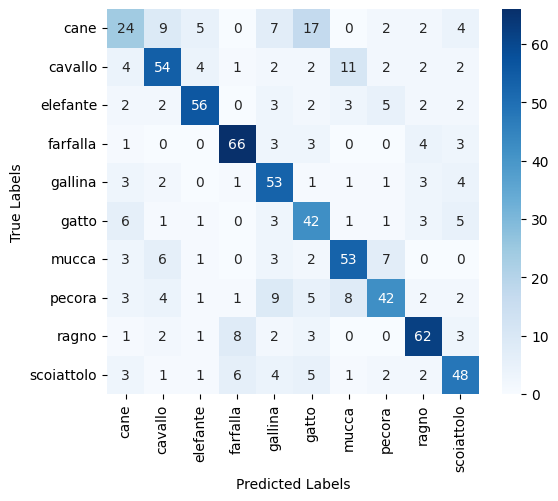

In [8]:
test_process(best_CNN)

The performance of this model has been evaluated using metrics such as accuracy, precision, recall, and F1-score. The overall accuracy is 66.67%, indicating that the model correctly classified approximately 67% of all samples. This demonstrates a moderate level of performance, but it also highlights the need for improvement. The precision score of 66.84% reflects the proportion of correct predictions, showing that some classes are classified more accurately than others. Similarly, the recall score is 66.67%, which aligns with the overall accuracy and indicates the model's ability to capture true positives. The F1-score, which balances precision and recall, is calculated as 66.36%, reflecting the model's ability to maintain a balance between accurate classifications and capturing all positive instances.

When examining class-specific performance, the model performs better on classes such as "ragno", "farfalla". However, it struggles with classes like "cane", where misclassifications are more frequent. The confusion matrix reveals significant confusion between visually similar classes, such as "mucca" and "cavallo" or "gatto" and "cane." This indicates the model's difficulty in distinguishing shared features between these classes.

### 1.7 Conclusion and interpretation

The model's performance on the test set achieved an overall accuracy of 67%, indicating a moderate level of success. Precision, recall, and F1-score values demonstrate that the model is capable of effectively classifying some classes but struggles with others. This highlights the model's inability to distinguish shared features between certain classes.

During training, several key challenges were encountered. The visual similarity between certain classes in the dataset made predictions more difficult for the model. Additionally, the risk of overfitting emerged as an issue in the later stages of training. The choice of learning rate also required careful consideration to balance stability and convergence speed.

Several improvements can be made to enhance the model's performance. Implementing data augmentation techniques can increase the diversity of the dataset and improve the model's generalization capability. Addressing class imbalance by oversampling underrepresented classes or using weighted loss functions can help improve per-class accuracy. Furthermore, leveraging more advanced pretrained models such as ResNet50 or MobileNet could facilitate the learning of more distinctive features.

In conclusion, the selected CNN architecture offers a balanced structure in terms of computational efficiency and learning capacity. However, the challenges faced in distinguishing visually similar classes indicate the need for further improvements. While the training strategy, particularly the use of a low learning rate and Adam optimizer, ensured stable convergence, performance can be further enhanced with advanced techniques. Overall, the model's performance is acceptable but has significant potential for improvement.

### 1.8 Kaggle test result

In [9]:
def Kaggle(best_model, model_name):
  test_dir = '/content/drive/My Drive/cnn_test'

  test_image_paths = [os.path.join(test_dir, img_name) for img_name in os.listdir(test_dir)]
  sorted_files = sorted(test_image_paths, key=lambda x: int(''.join(filter(str.isdigit, x))))

  test_images = []
  for img_path in sorted_files:
      img = Image.open(img_path).convert('RGB').resize((256, 256))
      img = transforms.ToTensor()(img)
      img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
      test_images.append(img)

  test_images = torch.stack(test_images)

  best_model.eval()
  predictions = []
  with torch.no_grad():
      for image in test_images:
          image = image.unsqueeze(0).to(device)
          output = best_model(image)
          predicted_class = output.argmax(dim=1).item()
          predictions.append(predicted_class)

  class_labels = {0: 'cane', 1: 'cavallo', 2: 'elefante', 3: 'farfalla', 4: 'gallina', 5: 'gatto', 6: 'mucca', 7: 'pecora', 8: 'ragno', 9: 'scoiattolo'}
  df = pd.DataFrame({'ID': range(1, len(predictions) + 1), 'Label': [class_labels[p] for p in predictions]})
  df.to_csv(f'{model_name}.csv', index=False)
  files.download(f'{model_name}.csv')

In [10]:
Kaggle(cnn_model, "rebuildCNN")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Kaggle result : 0.688 (username = RdncRc)


The model's accuracy on Kaggle was calculated as 68.8%, indicating a reasonable starting performance. While the model successfully classified many examples in the dataset, it is clear that it struggled with some classes, likely experiencing confusion between visually similar categories. This accuracy level is acceptable for a basic CNN or less complex architecture, but it is evident that the model needs to be improved to achieve higher accuracy levels.

## 2 Exploring transfer learning with ResNet50 and MobileNet

### 2.1. Introduction

In this task, fine-tuning has been applied to classify images in the Animal-10 dataset using pretrained models like ResNet-18 and MobileNetV2. The fine-tuning process involves replacing the final fully connected layer of these models to adapt them to the 10 classes in the Animal-10 dataset. In the initial stage, all layers of the model were frozen, and only the final layer was trained. Later, some deeper layers were unfrozen and trained, and finally, the entire model was unfrozen and trained end-to-end. This process was implemented to adapt the model efficiently to the new task.

Fine-tuning is a method used to adapt pretrained models to a new task or dataset. For instance, ResNet-18 and MobileNetV2 are models pretrained on ImageNet and have learned general features. The fine-tuning process adapts these general features to the new dataset, reducing training time and achieving better performance with limited data.

Freezing the early layers of the model and training only the final layer offers several advantages. First, general features are preserved since early layers predominantly learn basic features applicable to most types of images. Second, this approach allows the model to focus solely on the classification task specific to the Animal-10 dataset. Additionally, it is computationally efficient because only the final layer is trained, requiring fewer parameter updates and less time. In later stages, unfreezing deeper layers allows the model to learn more complex, dataset-specific features.

### 2.2 Load the pre-trained ResNet18 model


In [11]:
import torchvision.models as models

weights = models.ResNet18_Weights.DEFAULT
restnet_model_base = models.resnet18(weights = weights).to(device)

summary(restnet_model_base, (1, 3, 256, 256), col_names=["input_size", "output_size", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Trainable
ResNet                                   [1, 3, 256, 256]          [1, 1000]                 True
├─Conv2d: 1-1                            [1, 3, 256, 256]          [1, 64, 128, 128]         True
├─BatchNorm2d: 1-2                       [1, 64, 128, 128]         [1, 64, 128, 128]         True
├─ReLU: 1-3                              [1, 64, 128, 128]         [1, 64, 128, 128]         --
├─MaxPool2d: 1-4                         [1, 64, 128, 128]         [1, 64, 64, 64]           --
├─Sequential: 1-5                        [1, 64, 64, 64]           [1, 64, 64, 64]           True
│    └─BasicBlock: 2-1                   [1, 64, 64, 64]           [1, 64, 64, 64]           True
│    │    └─Conv2d: 3-1                  [1, 64, 64, 64]           [1, 64, 64, 64]           True
│    │    └─BatchNorm2d: 3-2             [1, 64, 64, 64]           [1, 64, 64, 64]           True
│    │    └─ReLU: 3

### 2.3 Modify the ResNet18 model for transfer learning

In [12]:
for param in restnet_model_base.parameters():
    param.requires_grad = False

restnet_model_base.fc = nn.Linear(512, 10).to(device)

for param in restnet_model_base.fc.parameters():
    param.requires_grad = True

crossEntropy = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(restnet_model_base.parameters(), lr=0.0001)

In [13]:
best_resnet_base, acc_base = train_process(restnet_model_base, crossEntropy, optimizer_base, "ResNet18-1")

Epoch	|ResNet18-1:	Train Loss	Val Loss	Acc
1	|		2.2928		2.1018		26.80%
2	|		1.9832		1.8597		46.40%
3	|		1.7399		1.6433		60.00%
4	|		1.5332		1.4461		69.47%
5	|		1.3694		1.3074		75.60%
6	|		1.2288		1.1723		79.07%
7	|		1.1089		1.0725		80.53%
8	|		1.0141		0.9945		81.47%
9	|		0.9307		0.9155		83.47%
10	|		0.8726		0.8545		84.40%
11	|		0.8131		0.7874		85.73%
12	|		0.7708		0.7662		86.13%
13	|		0.7150		0.7135		85.73%
14	|		0.6840		0.6943		86.93%
15	|		0.6554		0.6557		87.60%
16	|		0.6174		0.6309		87.33%
17	|		0.5918		0.6025		87.87%
18	|		0.5690		0.5951		88.80%
19	|		0.5536		0.5417		88.67%
20	|		0.5344		0.5547		88.27%
21	|		0.5150		0.5210		89.73%
22	|		0.5064		0.5074		88.40%
23	|		0.4748		0.5136		88.67%
24	|		0.4716		0.5042		88.00%
25	|		0.4660		0.4899		88.67%
26	|		0.4572		0.4617		89.47%
27	|		0.4376		0.4601		89.33%
28	|		0.4272		0.4476		88.67%
29	|		0.4271		0.4391		89.20%
30	|		0.4203		0.4421		89.20%

Best accuracy: 89.73% achieved at epoch 21 for ResNet18-1


In [14]:
import torchvision.models as models

weights = models.ResNet18_Weights.DEFAULT
restnet_model_second = models.resnet18(weights = weights).to(device)

for param in restnet_model_second.parameters():
    param.requires_grad = False

restnet_model_second.fc = nn.Linear(512, 10).to(device)

for param in restnet_model_second.fc.parameters():
    param.requires_grad = True

for name, param in restnet_model_second.named_parameters():
    if "layer3" in name or "layer4" in name:
        param.requires_grad = True

crossEntropy = nn.CrossEntropyLoss()
optimizer_second = torch.optim.Adam(restnet_model_second.parameters(), lr=0.0001)

In [15]:
best_resnet_second, acc_second = train_process(restnet_model_second, crossEntropy, optimizer_second, "ResNet18-2")

Epoch	|ResNet18-2:	Train Loss	Val Loss	Acc
1	|		0.8613		0.3512		90.40%
2	|		0.2361		0.2807		91.47%
3	|		0.1327		0.2355		92.93%
4	|		0.0884		0.2327		92.40%
5	|		0.0572		0.2002		94.53%
6	|		0.0424		0.2064		93.47%
7	|		0.0291		0.2299		92.80%
8	|		0.0246		0.2025		93.87%
9	|		0.0186		0.2405		93.07%
10	|		0.0154		0.2163		93.87%
11	|		0.0111		0.1980		94.27%
12	|		0.0088		0.2441		92.80%
13	|		0.0081		0.1895		94.93%
14	|		0.0075		0.2449		92.93%
15	|		0.0080		0.2126		94.40%
16	|		0.0064		0.1929		95.33%
17	|		0.0086		0.2503		92.93%
18	|		0.0121		0.2361		92.93%
19	|		0.0088		0.2307		93.87%
20	|		0.0056		0.1955		94.80%
21	|		0.0058		0.2143		94.40%
22	|		0.0060		0.1868		94.27%
23	|		0.0070		0.2230		93.87%
24	|		0.0074		0.2142		93.60%
25	|		0.0065		0.2326		93.87%
26	|		0.0058		0.2723		93.87%
27	|		0.0065		0.2620		94.27%
28	|		0.0030		0.2429		94.00%
29	|		0.0030		0.2305		93.73%
30	|		0.0076		0.2440		93.33%

Best accuracy: 95.33% achieved at epoch 16 for ResNet18-2


In [16]:
import torchvision.models as models

weights = models.ResNet18_Weights.DEFAULT
restnet_model_third = models.resnet18(weights = weights).to(device)

restnet_model_third.fc = nn.Linear(512, 10).to(device)

crossEntropy = nn.CrossEntropyLoss()
optimizer_third = torch.optim.Adam(restnet_model_third.parameters(), lr=0.0001)

In [17]:
best_resnet_third, acc_third = train_process(restnet_model_third, crossEntropy, optimizer_third, "ResNet18-3")

Epoch	|ResNet18-3:	Train Loss	Val Loss	Acc
1	|		0.8544		0.4074		87.47%
2	|		0.2349		0.2991		90.53%
3	|		0.1391		0.2541		93.47%
4	|		0.0769		0.2395		93.07%
5	|		0.0453		0.2323		92.80%
6	|		0.0375		0.2312		92.40%
7	|		0.0332		0.2637		92.00%
8	|		0.0220		0.2274		93.33%
9	|		0.0170		0.2393		93.47%
10	|		0.0149		0.1941		93.73%
11	|		0.0104		0.2180		93.07%
12	|		0.0099		0.2273		94.53%
13	|		0.0109		0.2172		93.60%
14	|		0.0084		0.2236		93.20%
15	|		0.0057		0.2619		92.40%
16	|		0.0127		0.3670		89.60%
17	|		0.0191		0.2635		92.53%
18	|		0.0223		0.3284		90.67%
19	|		0.0184		0.2839		92.27%
20	|		0.0113		0.2338		92.93%
21	|		0.0086		0.2617		92.27%
22	|		0.0085		0.2389		93.73%
23	|		0.0053		0.2152		94.27%
24	|		0.0031		0.2230		93.73%
25	|		0.0026		0.2120		94.53%
26	|		0.0024		0.2082		94.53%
27	|		0.0027		0.2177		93.87%
28	|		0.0028		0.2075		92.80%
29	|		0.0018		0.1904		94.93%
30	|		0.0018		0.2087		94.40%

Best accuracy: 94.93% achieved at epoch 29 for ResNet18-3


In [18]:
acc_s = max(acc_base, acc_second, acc_third)

if acc_s == acc_third:
    best_ResNet = best_resnet_third
elif acc_s == acc_second:
    best_ResNet = best_resnet_second
elif acc_s == acc_base:
    best_ResNet = best_resnet_base

print(f"Best ResNet selected with accuracy: {acc_s * 100:.2f}%")

Best ResNet selected with accuracy: 95.33%


When evaluating the performance of the three models, Model 2 emerged as the best-performing model, achieving the highest validation accuracy. This performance is a result of its balanced approach, which leverages both computational efficiency and the ability to learn more complex features. While not all layers were trained, Model 2 demonstrated significant adaptability, making it particularly suitable for scenarios where a balance between computational cost and accuracy is essential.

Model 3 delivered strong performance. Although it did not surpass Model 2, its success stems from the training of all layers, enabling the model to learn both low-level and high-level features specific to the dataset. This full adaptation results in robust predictive capabilities, albeit at the expense of higher computational cost and longer training time. Model 3 is ideal for use cases where maximum accuracy is critical, and computational resources are sufficient.

Model 1, on the other hand, the lowest among the three models. Since only the final layer was trained, its ability to adapt to the dataset's specific features was limited. However, its primary advantage lies in its minimal computational cost and faster training time, making it a viable option for scenarios where efficiency and resource constraints are the main priorities.

In conclusion, Model 2 provides the optimal trade-off between performance and efficiency, making it the most practical choice in many situations. Model 3 excels when accuracy is paramount, while Model 1 serves as an efficient solution for rapid training with limited resources.

### 2.4 Evaluate the fine-tuned ResNet18 model

Accuracy: 0.9320
 Precision: 0.9319
 Recall: 0.9320
 F1: 0.9318



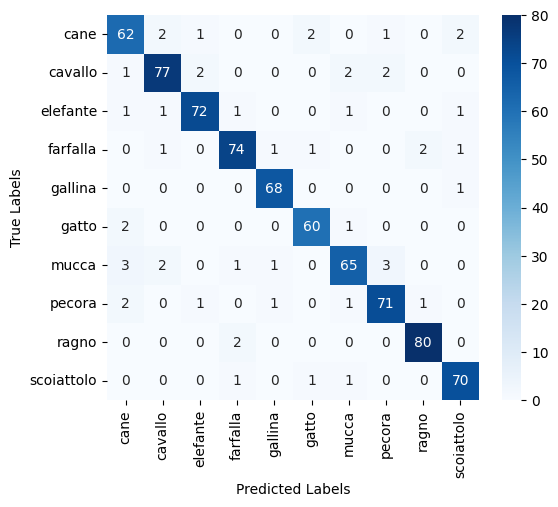

In [19]:
test_process(best_ResNet)

The metrics of the ResNet18 model demonstrate that it has performed quite successfully. The consistency between precision and recall values indicates that the model is effective not only in making accurate classifications but also in correctly identifying positive classes. This proves that the model can accurately distinguish most of the classes. However, some confusion among certain classes is noticeable, likely due to the visual similarities between these classes. Overall, the model exhibits a high accuracy rate and requires improvements in only a few classes.

The ResNet18 model shows a clear superiority compared to the CNN model designed from scratch. ResNet18, with its pretrained ImageNet weights, has the ability to learn more complex and distinctive features. These features have been successfully adapted to the Animal-10 dataset, significantly enhancing the model's accuracy. In contrast, the CNN model trained from scratch has a more limited architecture and learning capacity, which prevented it from achieving the same level of performance. This is a direct result of ResNet18's more robust architecture and reliance on pretrained knowledge.

### 2.5 Kaggle test result

In [20]:
Kaggle(best_ResNet, "ResNet18")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Kaggle result : 0.953 (username = RdncRc)

A Kaggle score of 0.953 demonstrates that the model has successfully performed classification, proving that the choice of model, fine-tuning strategy, and training processes were effective. However, considering the confusion observed in some classes and the computational costs, this performance could be further improved in the future by using lighter models or making dataset-specific enhancements.

### 2.7. Load the pre-trained MobileNet model

In [21]:
import torchvision.models as models

weights = models.MobileNet_V2_Weights.DEFAULT
mobilenet_model_base = models.mobilenet_v2(weights = weights).to(device)

summary(mobilenet_model_base, input_size=(1, 3, 256, 256), col_names=["input_size", "output_size", "trainable"])

Layer (type:depth-idx)                             Input Shape               Output Shape              Trainable
MobileNetV2                                        [1, 3, 256, 256]          [1, 1000]                 True
├─Sequential: 1-1                                  [1, 3, 256, 256]          [1, 1280, 8, 8]           True
│    └─Conv2dNormActivation: 2-1                   [1, 3, 256, 256]          [1, 32, 128, 128]         True
│    │    └─Conv2d: 3-1                            [1, 3, 256, 256]          [1, 32, 128, 128]         True
│    │    └─BatchNorm2d: 3-2                       [1, 32, 128, 128]         [1, 32, 128, 128]         True
│    │    └─ReLU6: 3-3                             [1, 32, 128, 128]         [1, 32, 128, 128]         --
│    └─InvertedResidual: 2-2                       [1, 32, 128, 128]         [1, 16, 128, 128]         True
│    │    └─Sequential: 3-4                        [1, 32, 128, 128]         [1, 16, 128, 128]         True
│    └─InvertedResidual: 

### 2.8 Modify the MobileNet model for transfer learning

In [22]:
for param in mobilenet_model_base.features.parameters():
    param.requires_grad = False

mobilenet_model_base.classifier = nn.Linear(1280, 10).to(device)

for param in mobilenet_model_base.classifier.parameters():
    param.requires_grad = True

crossEntropy = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(mobilenet_model_base.parameters(), lr=0.0001)

In [23]:
best_mobilenet_base, acc_base = train_process(mobilenet_model_base, crossEntropy, optimizer_base, "MobileNet18-1")

Epoch	|MobileNet18-1:	Train Loss	Val Loss	Acc
1	|		2.1917		2.0649		49.73%
2	|		1.9702		1.8679		74.53%
3	|		1.7730		1.6864		79.20%
4	|		1.6019		1.5187		82.80%
5	|		1.4441		1.3847		86.27%
6	|		1.3281		1.2467		86.93%
7	|		1.2078		1.1574		87.47%
8	|		1.1117		1.0766		87.87%
9	|		1.0234		1.0064		87.20%
10	|		0.9573		0.9391		86.93%
11	|		0.8916		0.8667		88.27%
12	|		0.8416		0.8245		87.73%
13	|		0.7920		0.7880		88.40%
14	|		0.7506		0.7768		86.80%
15	|		0.7182		0.7092		89.60%
16	|		0.6740		0.6790		89.60%
17	|		0.6533		0.6721		88.27%
18	|		0.6268		0.6339		88.53%
19	|		0.6097		0.6300		87.73%
20	|		0.5779		0.6002		88.80%
21	|		0.5675		0.5589		89.73%
22	|		0.5426		0.5557		89.33%
23	|		0.5310		0.5433		88.67%
24	|		0.5119		0.5228		89.73%
25	|		0.5009		0.5149		90.00%
26	|		0.4867		0.4993		89.20%
27	|		0.4826		0.5080		89.60%
28	|		0.4623		0.4644		90.80%
29	|		0.4501		0.4841		89.60%
30	|		0.4527		0.4692		89.60%

Best accuracy: 90.80% achieved at epoch 28 for MobileNet18-1


In [24]:
import torchvision.models as models

weights = models.MobileNet_V2_Weights.DEFAULT
mobilenet_model_second = models.mobilenet_v2(weights = weights).to(device)

mobilenet_model_second.classifier = nn.Linear(1280, 10).to(device)

crossEntropy = nn.CrossEntropyLoss()
optimizer_second = torch.optim.Adam(mobilenet_model_second.parameters(), lr=0.0001)

In [25]:
best_mobilenet_second, acc_second = train_process(mobilenet_model_second, crossEntropy, optimizer_second, "MobileNet18-2")

Epoch	|MobileNet18-2:	Train Loss	Val Loss	Acc
1	|		1.7107		0.9769		87.07%
2	|		0.6248		0.4137		90.00%
3	|		0.2936		0.2691		92.93%
4	|		0.1937		0.2454		92.40%
5	|		0.1385		0.2162		93.87%
6	|		0.1056		0.2058		94.27%
7	|		0.0776		0.1978		93.47%
8	|		0.0653		0.2074		93.87%
9	|		0.0487		0.2018		94.53%
10	|		0.0353		0.1807		94.67%
11	|		0.0276		0.2093		93.87%
12	|		0.0255		0.2061		94.93%
13	|		0.0216		0.2069		94.67%
14	|		0.0185		0.2168		94.27%
15	|		0.0187		0.1928		95.20%
16	|		0.0174		0.1907		95.47%
17	|		0.0137		0.1943		95.47%
18	|		0.0149		0.2066		93.87%
19	|		0.0152		0.1803		95.07%
20	|		0.0155		0.2174		93.87%
21	|		0.0157		0.2412		93.87%
22	|		0.0120		0.1994		94.80%
23	|		0.0103		0.2051		95.07%
24	|		0.0125		0.2125		94.67%
25	|		0.0120		0.1924		94.80%
26	|		0.0072		0.1820		94.67%
27	|		0.0057		0.2224		94.93%
28	|		0.0090		0.2415		94.00%
29	|		0.0073		0.2001		94.27%
30	|		0.0077		0.2399		94.27%

Best accuracy: 95.47% achieved at epoch 16 for MobileNet18-2


In [26]:
acc_s = max(acc_base, acc_second)

if acc_s == acc_second:
    best_MobileNet = best_mobilenet_second
elif acc_s == acc_base:
    best_MobileNet = best_mobilenet_base

print(f"Best MobileNet selected with accuracy: {acc_s * 100:.2f}%")

Best MobileNet selected with accuracy: 95.47%


Model 1 significantly improved its validation accuracy throughout the training process. The consistent decrease in both training and validation losses indicates that the model converged properly. However, after a certain epoch, the increase in validation accuracy became quite limited.

In contrast, Model 2 demonstrated superior performance in terms of validation accuracy. This suggests that Model 2 has a higher generalization capacity and is better at distinguishing between the classes in the dataset.

Model 2 outperformed Model 1 in terms of validation accuracy. The reason for this success lies in the fact that deeper layers of Model 2 were unfrozen and trained. This allowed Model 2 to leverage both the pretrained features and learn more complex features specific to the dataset. On the other hand, Model 1, having only trained the final layers, had a more limited learning capacity.

### 2.9 Evaluate the fine-tuned MobileNet model

Accuracy: 0.9440
 Precision: 0.9445
 Recall: 0.9440
 F1: 0.9439



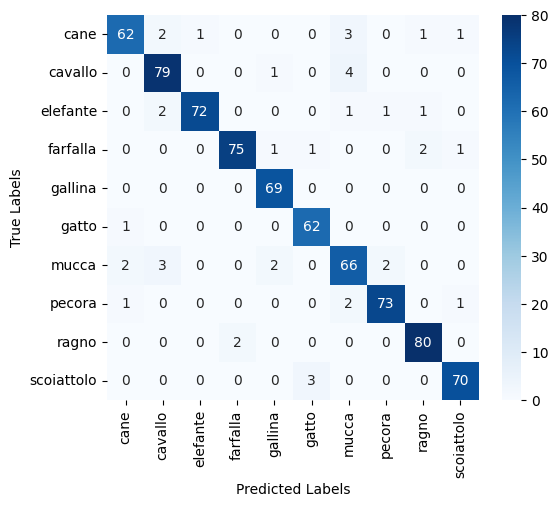

In [27]:
test_process(best_MobileNet)

The metrics of the MobileNetV2 model demonstrate that it has achieved excellent performance, with high accuracy, precision, recall, and F1-score values. Thanks to its lightweight architecture and pretrained weights, the model provides an efficient solution in terms of both performance and computational cost. The consistency between precision and recall indicates that the model is effective not only in making accurate classifications but also in correctly identifying positive classes. However, minor confusion between some visually similar classes suggests areas where improvements can be made.

When compared to the CNN model designed from scratch, MobileNetV2 shows clear superiority. While the CNN model is effective to a certain extent, it lacks the depth and pretrained feature extraction capabilities of MobileNetV2. Leveraging its pretrained weights from ImageNet, MobileNetV2 can learn more complex and distinctive features and adapt them effectively to the Animal-10 dataset. This enables MobileNetV2 to achieve significantly higher accuracy and generalization compared to the CNN model, which has a more limited architecture and learning capacity.

When comparing MobileNetV2 and ResNet18, both models demonstrate strong performance, but their differences lie in efficiency and adaptability. MobileNetV2 is designed as a lightweight architecture, making it computationally efficient and suitable for scenarios with limited resources or where faster inference is required. It achieves competitive accuracy, precision, and recall while maintaining lower computational costs. This efficiency makes it a great choice for real-time applications or deployment on devices with limited hardware.

On the other hand, ResNet18 benefits from a deeper architecture, which allows it to learn more detailed and complex features. This gives ResNet18 a slight edge in scenarios where maximum accuracy is prioritized over computational efficiency. Its ability to capture richer feature representations makes it more suitable for datasets with highly complex patterns or subtle class differences.

### 2.10 Kaggle test result

In [28]:
Kaggle(best_MobileNet, "MobileNetV2")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Kaggle result : 0.949 (username = RdncRc)

The 94.9% accuracy score achieved by the MobileNetV2 model on Kaggle demonstrates its outstanding performance. This result proves that MobileNetV2 can achieve high accuracy despite its lightweight structure. The success of the model stems from its ability to leverage pretrained ImageNet weights to learn more complex and distinctive features. These features have been effectively adapted to the Animal-10 dataset, resulting in high accuracy.

## 3 Analyze advantages and disadvantages



The comparison between transfer learning and training from scratch shows that transfer learning is generally more advantageous. Transfer learning accelerates training by leveraging pretrained model weights and achieves high accuracy with less data. Models like ResNet18 and MobileNetV2 utilize features learned on ImageNet to deliver strong generalization performance, even with limited datasets. In contrast, training from scratch allows for full optimization of the model for the specific task but requires significantly more data and computational power. This approach becomes particularly meaningful for large datasets.

In the comparison between MobileNetV2 and ResNet18, MobileNetV2's lightweight structure and low computational cost stand out. These characteristics make MobileNetV2 an ideal choice for resource-constrained environments or real-time applications. ResNet18, on the other hand, benefits from its deeper architecture, enabling it to learn more complex features and providing a slight accuracy advantage. However, this increase in accuracy typically comes with higher computational costs. The fact that both models achieve very high accuracy demonstrates that transfer learning is an exceptionally effective method for classification tasks.

Compared to the CNN model designed from scratch, models utilizing transfer learning have a clear superiority. While the CNN model can only learn limited features, models like ResNet18 and MobileNetV2, which rely on pretrained knowledge, can extract more complex and distinctive features. This makes transfer learning models superior in terms of both accuracy and generalization capability.








| **Metric**              | **rebuildCNN** | **ResNet18**       | **MobileNetV2**    |
|-------------------------|-------------------------|---------------------|---------------------|
| **Validation Accuracy** | ~67%                   | ~93%               | ~94%               |
| **Precision**           | ~67%                   | ~93%             | ~94%             |
| **Recall**              | ~67%                   | ~93%             | ~94%             |
| **F1-Score**            | ~66%                   | ~93%             | ~94%             |
| **Training Time**       | High                   | Moderate           | Low                |
| **Computational Cost**  | High                   | Moderate           | Low                |
| **Model Complexity**    | Simple                 | Moderate           | Lightweight         |
| **Adaptability**        | Limited                | High               | High               |
